## **Import Libraries**

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

## **Load Dataset**

In [196]:
example_pats = pd.read_csv('../data/med_events.csv')
example_pats.head(15)

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1974,01/13/2022,2,medA,60
1,1542,09/05/2023,1,medA,30
2,1292,07/04/2023,1,medB,90
3,1787,08/04/2023,2,medB,60
4,1837,11/30/2022,2,medA,30
5,1859,08/11/2023,1,medA,90
6,1059,11/16/2022,2,medB,60
7,1522,08/17/2022,2,medB,60
8,1370,06/14/2022,1,medA,30
9,1039,02/14/2023,2,medA,60


## **Rename Columns**

In [197]:
tidy = example_pats
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]


## **Convert Date Column to Datetime**

In [198]:
tidy['eksd'] = pd.to_datetime(tidy['eksd'])
tidy.head()

,pnr,eksd,perday,ATC,dur_original
0,1974,2022-01-13,2,medA,60
1,1542,2023-09-05,1,medA,30
2,1292,2023-07-04,1,medB,90
3,1787,2023-08-04,2,medB,60
4,1837,2022-11-30,2,medA,30


## **Sessa Empirical Estimator (K-Means)**

In [199]:
def See(arg1, tidy):
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data
    drug_see_p1 = (drug_see_p1
                   .sort_values(['pnr', 'eksd'])
                   .groupby('pnr')
                   .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
                   .reset_index(drop=True))
    
    # Remove NAs and sample one row per patient
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(
        lambda x: x.iloc[np.random.randint(len(x))]
    ).reset_index(drop=True)
    
    # Select columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - 
                                    drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain 80% of ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(dfper['x'], dfper['y'])
    ax1.set_title('80% ECDF')
    ax2.plot(x, y)
    ax2.set_title('100% ECDF')
    plt.show()
    
    # Density plot of log intervals
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= dfper['x'].max()]
    # Add validation check for valid intervals
    valid_intervals = drug_see_p2['event.interval'].astype(float)
    valid_intervals = valid_intervals[np.isfinite(valid_intervals) & (valid_intervals > 0)]
    
    if len(valid_intervals) > 0:
        kde = gaussian_kde(np.log(valid_intervals))
        x_range = np.linspace(np.log(valid_intervals.min()), 
                            np.log(valid_intervals.max()), 100)
        plt.figure()
        plt.plot(x_range, kde(x_range))
        plt.title('Log(event interval)')
        plt.show()
    else:
        print("Warning: No valid intervals found for density estimation")
        return None
    
    # Prepare data for clustering
    a = np.column_stack((x_range, kde(x_range)))
    a = (a - np.mean(a, axis=0)) / np.std(a, axis=0)
    
    # Find optimal number of clusters
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        kmeans.fit(dfper[['x']])
        score = silhouette_score(dfper[['x']], kmeans.labels_)
        silhouette_scores.append(score)
    
    max_cluster = K[np.argmax(silhouette_scores)]
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
    
    # Calculate cluster statistics
    cluster_stats = pd.DataFrame()
    for cluster in range(max_cluster):
        cluster_data = np.log(dfper[dfper['cluster'] == cluster]['x'])
        stats_dict = {
            'Cluster': cluster,
            'Minimum': np.exp(cluster_data.min()),
            'Maximum': np.exp(cluster_data.max()),
            'Median': np.exp(cluster_data.median())
        }
        cluster_stats = pd.concat([cluster_stats, pd.DataFrame([stats_dict])], 
                                ignore_index=True)
    
    # Process results
    results = pd.merge(
        drug_see_p1,
        cluster_stats,
        how='cross'
    )
    
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    results = results.dropna(subset=['Final_cluster'])
    
    # Get most frequent cluster
    t1 = results['Cluster'].mode().iloc[0]
    t1_merged = results[results['Cluster'] == t1][['Cluster', 'pnr', 'Median']].iloc[0]
    
    # Final processing
    drug_see_p1 = pd.merge(drug_see_p1, results[['pnr', 'Median', 'Cluster']], 
                          on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna('0')
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - 
                               drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Final merge and processing
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
    
    return drug_see_p0

## **Sessa Empirical Estimator (DBScan)**

In [200]:
def See_dbscan(arg1, tidy):
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data
    drug_see_p1 = (drug_see_p1
                   .sort_values(['pnr', 'eksd'])
                   .groupby('pnr')
                   .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
                   .reset_index(drop=True))
    
    # Remove NAs and sample one row per patient
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(
        lambda x: x.iloc[np.random.randint(len(x))]
    ).reset_index(drop=True)
    
    # Select columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - 
                                    drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain 80% of ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plotting ECDF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(dfper['x'], dfper['y'])
    ax1.set_title('80% ECDF')
    ax2.plot(x, y)
    ax2.set_title('100% ECDF')
    plt.show()
    
    # Density plot of log intervals
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= dfper['x'].max()]
    kde = gaussian_kde(np.log(drug_see_p2['event.interval'].astype(float)))
    x_range = np.linspace(np.log(drug_see_p2['event.interval'].min()), 
                         np.log(drug_see_p2['event.interval'].max()), 100)
    plt.figure()
    plt.plot(x_range, kde(x_range))
    plt.title('Log(event interval)')
    plt.show()
    
    # Prepare data for DBSCAN
    X = dfper[['x']].values
    X_scaled = StandardScaler().fit_transform(X)
    
    # DBSCAN clustering
    # eps and min_samples can be adjusted based on your data
    dbscan = DBSCAN(eps=0.3, min_samples=5)
    dfper['cluster'] = dbscan.fit_predict(X_scaled)
    
    # Plot clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clusters')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')
    plt.show()
    
    # Calculate cluster statistics
    cluster_stats = []
    for cluster in sorted(dfper['cluster'].unique()):
        cluster_data = np.log(dfper[dfper['cluster'] == cluster]['x'])
        if len(cluster_data) > 0:  # Check if cluster has data
            stats_dict = {
                'Cluster': cluster,
                'Minimum': np.exp(cluster_data.min()),
                'Maximum': np.exp(cluster_data.max()),
                'Median': np.exp(cluster_data.median())
            }
            cluster_stats.append(stats_dict)
    
    cluster_stats = pd.DataFrame(cluster_stats)
    
    # Handle noise points (cluster = -1) separately
    if -1 in dfper['cluster'].unique():
        noise_data = dfper[dfper['cluster'] == -1]
        print(f"Number of noise points: {len(noise_data)}")
    
    # Process results
    results = pd.merge(
        drug_see_p1,
        cluster_stats,
        how='cross'
    )
    
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    results = results.dropna(subset=['Final_cluster'])
    
    # Get most frequent non-noise cluster
    valid_clusters = results[results['Cluster'] != -1]['Cluster']
    if len(valid_clusters) > 0:
        t1 = valid_clusters.mode().iloc[0]
        t1_merged = results[results['Cluster'] == t1][['Cluster', 'pnr', 'Median']].iloc[0]
    else:
        # Handle case where all points might be noise
        t1_merged = results[['Cluster', 'pnr', 'Median']].iloc[0]
    
    # Final processing
    drug_see_p1 = pd.merge(drug_see_p1, results[['pnr', 'Median', 'Cluster']], 
                          on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna(-1)  # Use -1 for unassigned
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - 
                               drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Final merge and processing
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(-1)
    
    return drug_see_p0

## **Assumption Testing: Prescription Interval Analysis**

This function examines prescription patterns over time using boxplots.

In [201]:
def see_assumption(arg1):
    """
    Analyze prescription patterns over time with boxplots
    
    Parameters:
    arg1 (pd.DataFrame): DataFrame containing prescription data
    
    Returns:
    matplotlib.figure.Figure: Boxplot visualization
    """
    # Sort and create lagged column
    arg1 = (arg1.sort_values(['pnr', 'eksd'])
            .groupby('pnr')
            .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
            .reset_index(drop=True))
    
    # Create sequence numbers
    drug_see2 = (arg1.groupby('pnr')
                 .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))
                 .reset_index(drop=True))
    
    # Filter for p_number >= 2
    drug_see2 = drug_see2[drug_see2['p_number'] >= 2]
    
    # Select required columns
    drug_see2 = drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate duration
    drug_see2['Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days
    
    # Convert p_number to string for plotting
    drug_see2['p_number'] = drug_see2['p_number'].astype(str)
    
    # Calculate median of medians
    medians_of_medians = (drug_see2.groupby('pnr')['Duration']
                         .median()
                         .median())
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Create boxplot using seaborn
    sns.boxplot(x='p_number', y='Duration', data=drug_see2)
    
    # Add horizontal line for median of medians
    plt.axhline(y=medians_of_medians, color='red', linestyle='--', 
                label=f'Median of medians: {medians_of_medians:.1f}')
    
    # Customize plot
    plt.title('Duration Between Prescriptions by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

## **Function Execution and Results**

Calling the functions with test data.

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1072346031.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(n=1)).reset_index(drop=True)


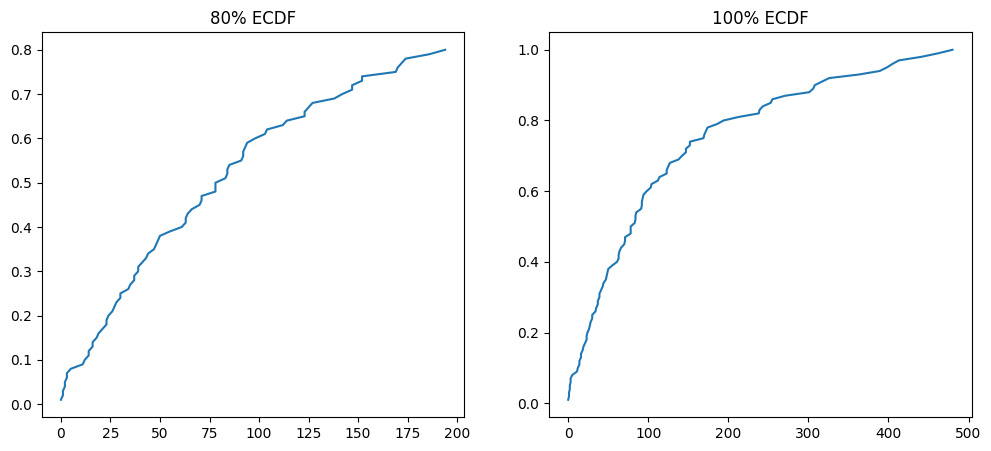

ValueError: Can only compare identically-labeled Series objects

In [202]:
medA_SEEKmeans = See('medA', tidy)
medA_SEEKmeans.head()

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3155958533.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3155958533.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(


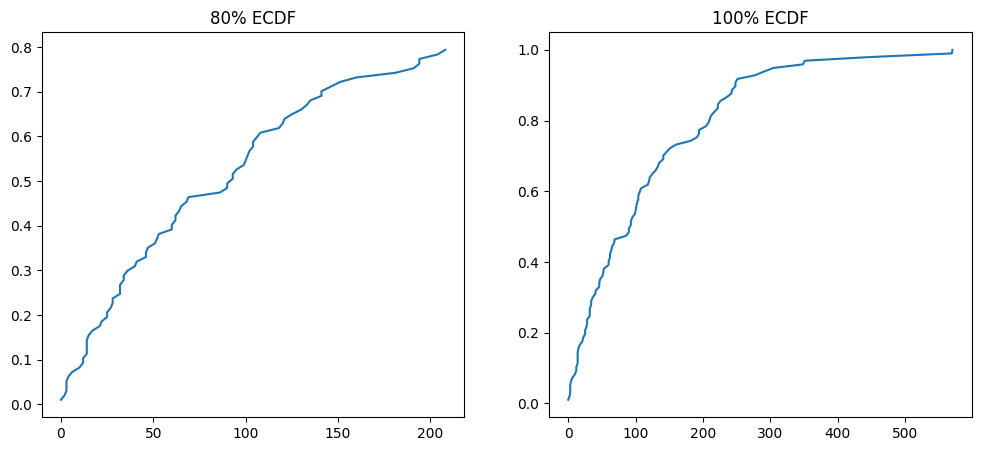

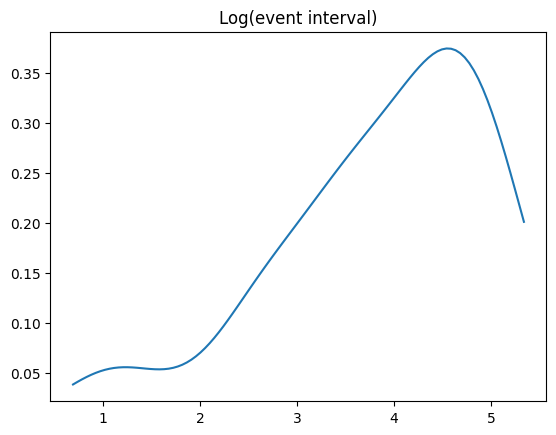

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pnr,eksd,perday,ATC,dur_original,Median,Cluster
0,1292,2023-07-04,1,medB,90,120.498963,1.0
1,1787,2023-08-04,2,medB,60,28.000000,0.0
2,1059,2022-11-16,2,medB,60,28.000000,0.0
3,1522,2022-08-17,2,medB,60,28.000000,0.0
4,1096,2022-03-30,2,medB,60,120.498963,1.0


In [188]:
medB_SEEKmeans = See('medB', tidy)
medB_SEEKmeans.head()

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))


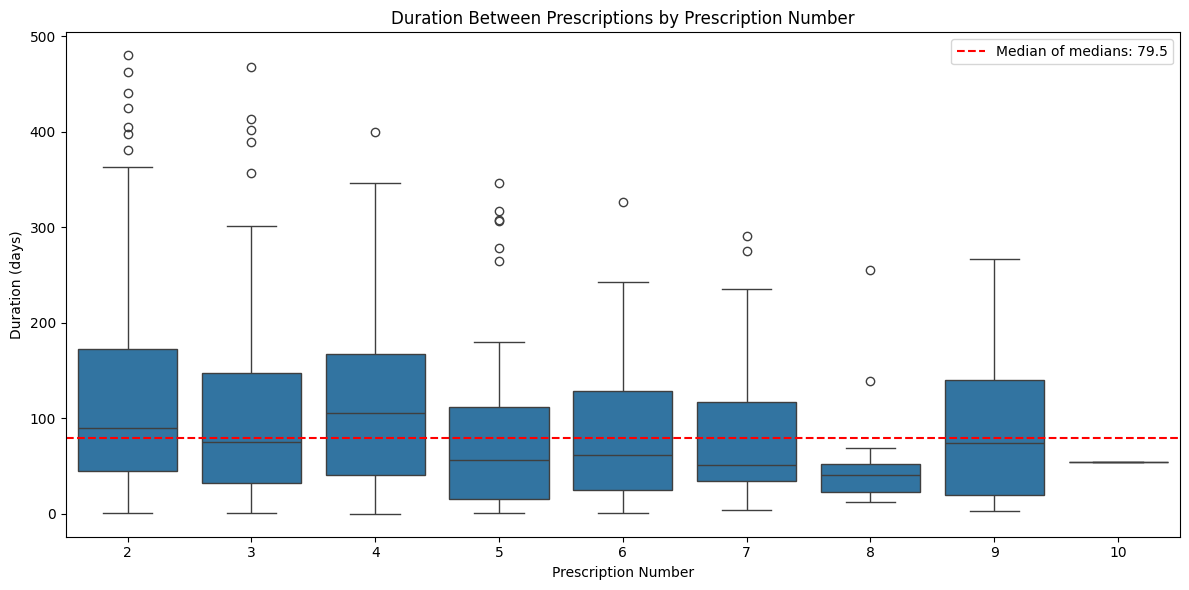

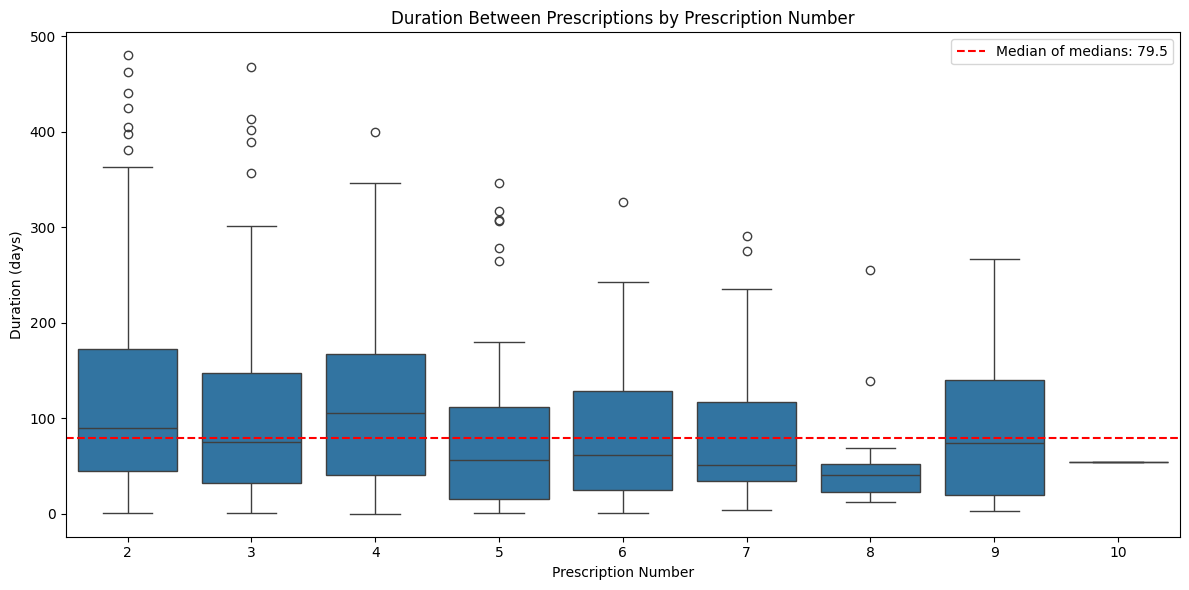

In [189]:
see_assumption(medA_SEEKmeans)

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))


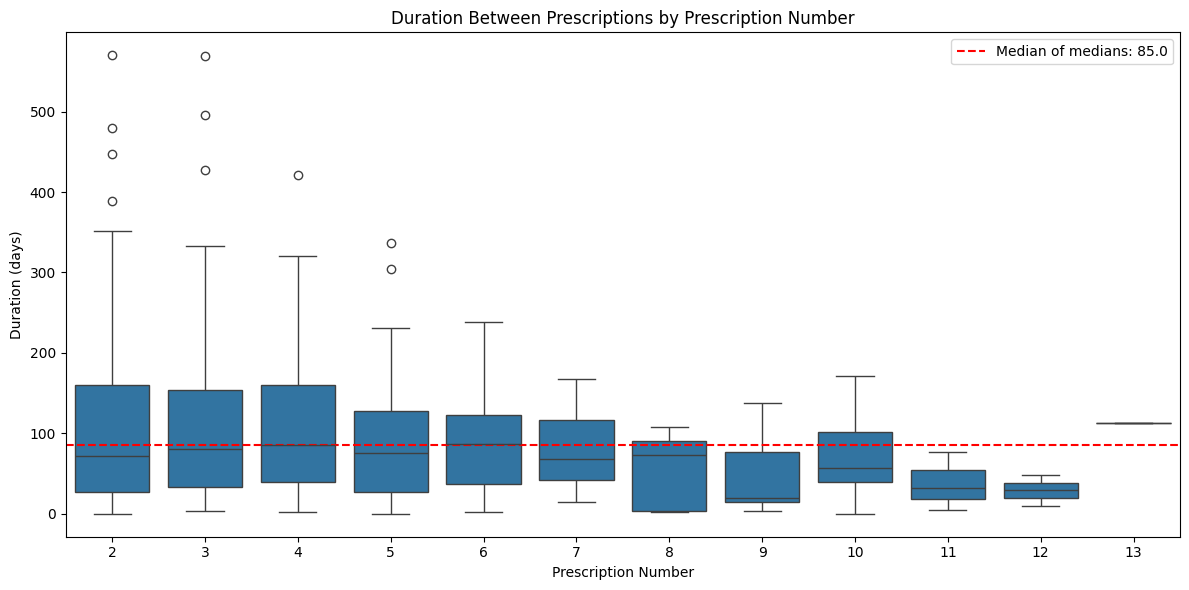

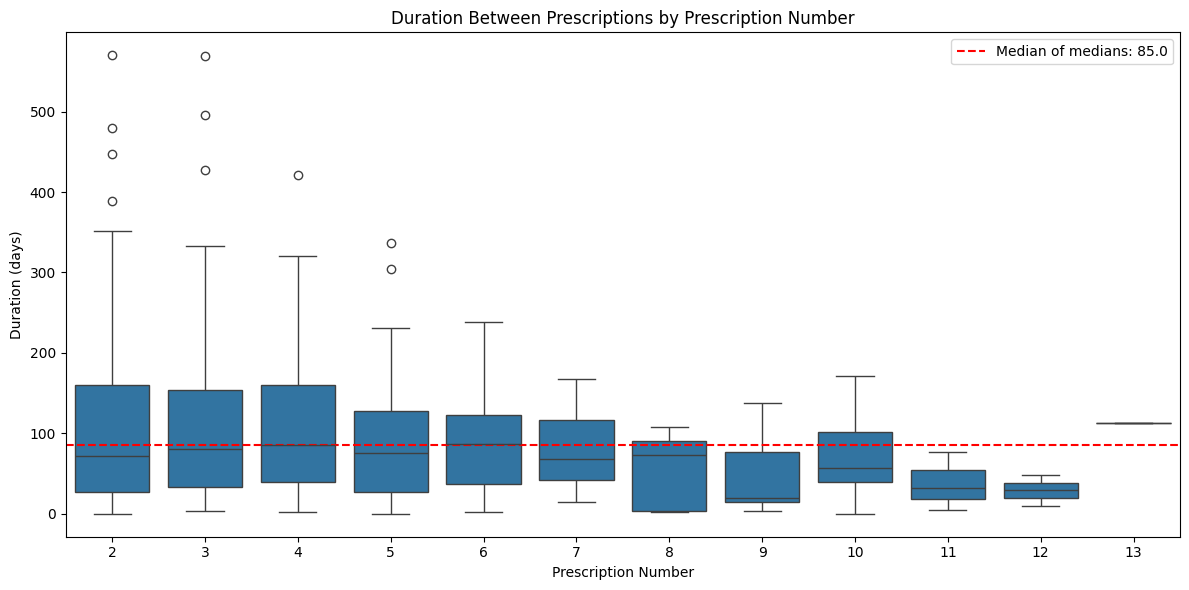

In [ ]:
see_assumption(medB_SEEKmeans)

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3399173172.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3399173172.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(


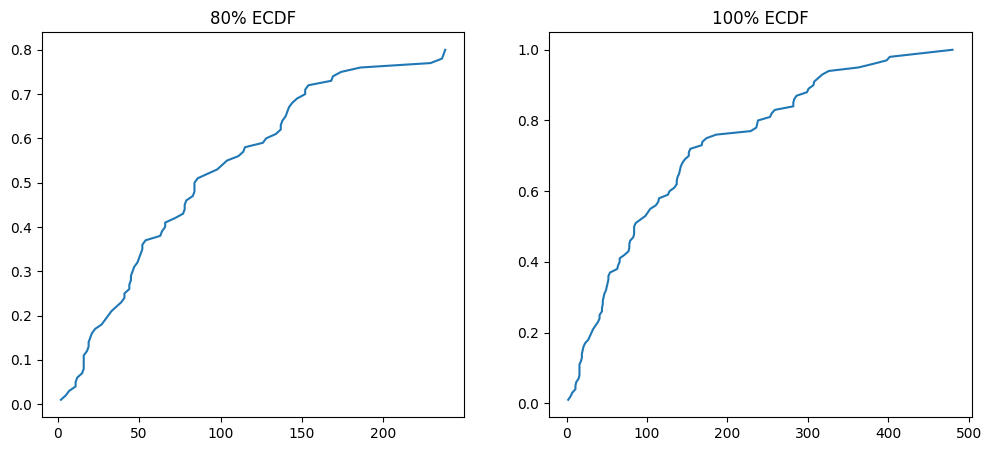

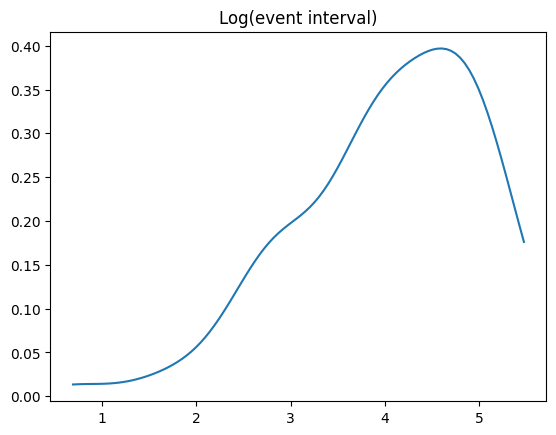

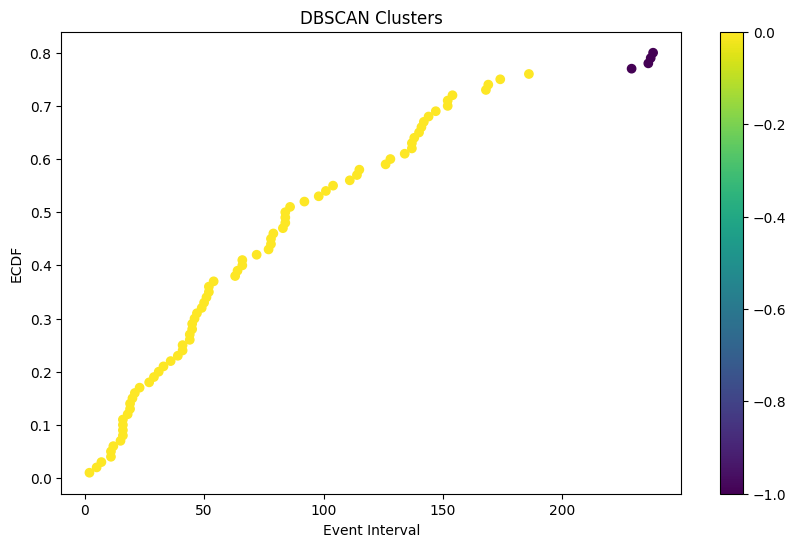

Number of noise points: 4


,pnr,eksd,perday,ATC,dur_original,Median,Cluster
0,1974,2022-01-13,2,medA,60,63.498031,-1.0
1,1542,2023-09-05,1,medA,30,63.498031,0.0
2,1837,2022-11-30,2,medA,30,63.498031,0.0
3,1859,2023-08-11,1,medA,90,63.498031,0.0
4,1370,2022-06-14,1,medA,30,63.498031,0.0


In [ ]:
medA_SEEDBScan = See_dbscan('medA', tidy)
medA_SEEDBScan.head()

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3399173172.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/3399173172.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(


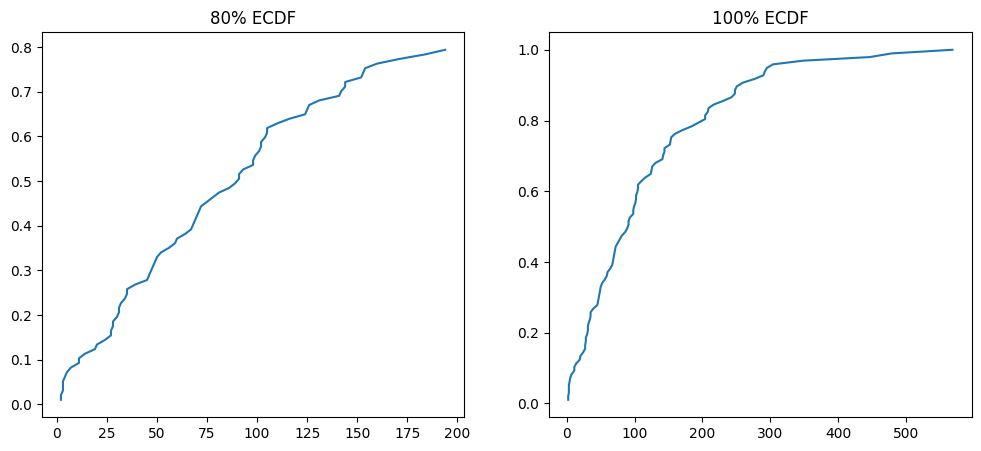

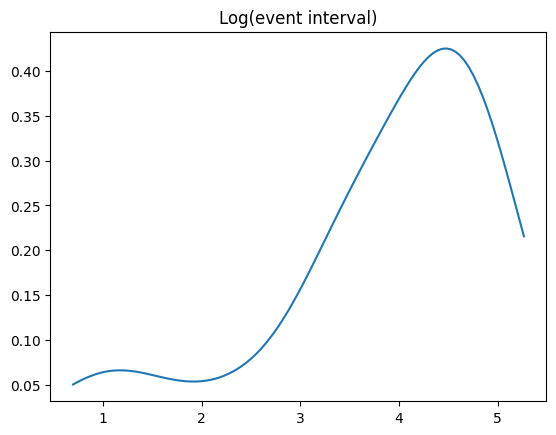

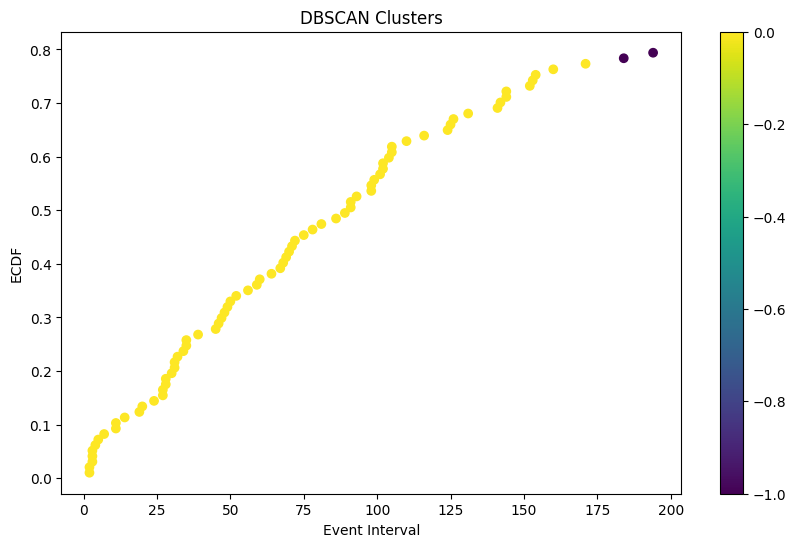

Number of noise points: 2


,pnr,eksd,perday,ATC,dur_original,Median,Cluster
0,1292,2023-07-04,1,medB,90,67.0,0.0
1,1787,2023-08-04,2,medB,60,67.0,0.0
2,1059,2022-11-16,2,medB,60,67.0,0.0
3,1522,2022-08-17,2,medB,60,67.0,0.0
4,1096,2022-03-30,2,medB,60,67.0,0.0
...,...,...,...,...,...,...,...
546,1292,2023-06-07,1,medB,30,67.0,0.0
547,1299,2023-05-18,2,medB,30,67.0,0.0
548,1209,2022-09-15,2,medB,30,67.0,0.0
549,1578,2022-11-27,1,medB,30,67.0,0.0


In [192]:
medB_SEEDBScan = See_dbscan('medB', tidy)
medB_SEEDBScan

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))


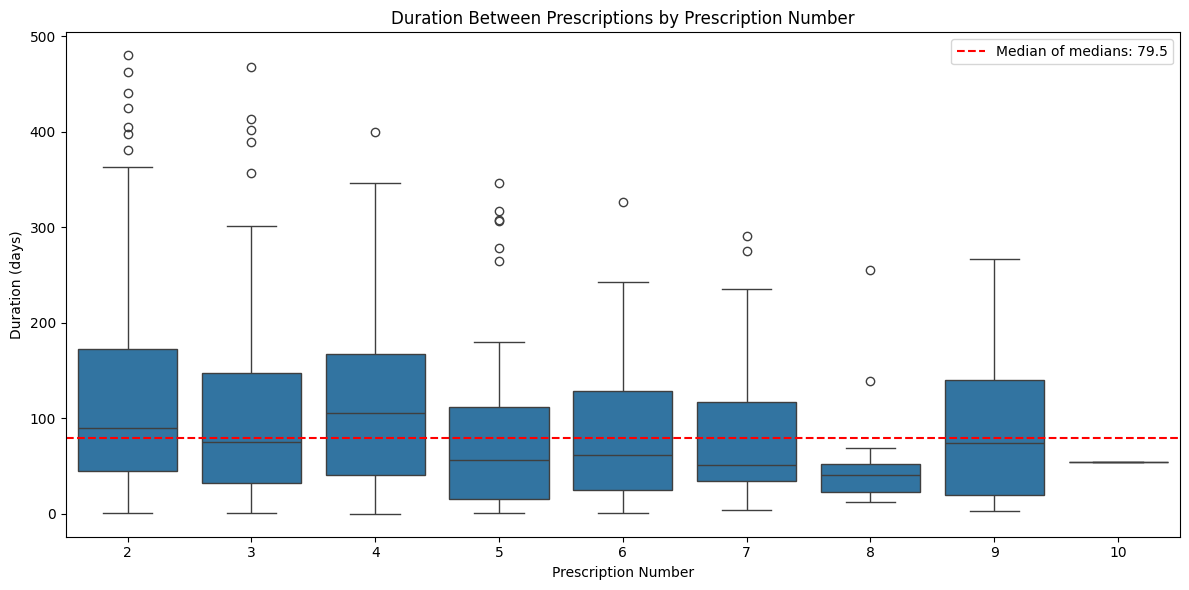

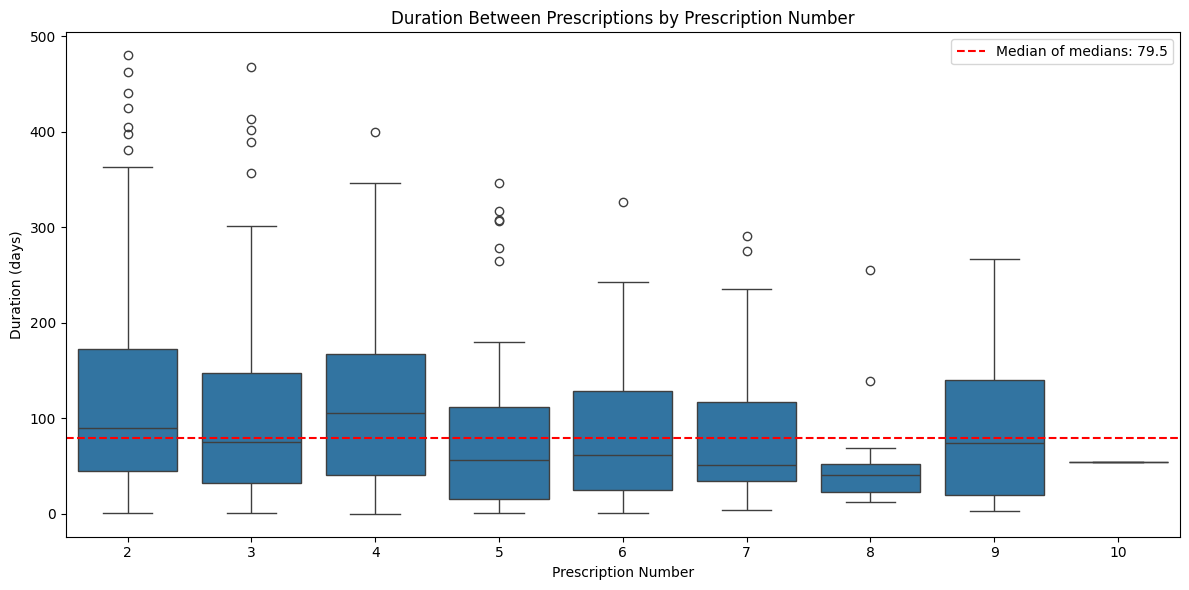

In [ ]:
see_assumption(medA_SEEDBScan)

/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
/var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/ipykernel_8833/1313513996.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))


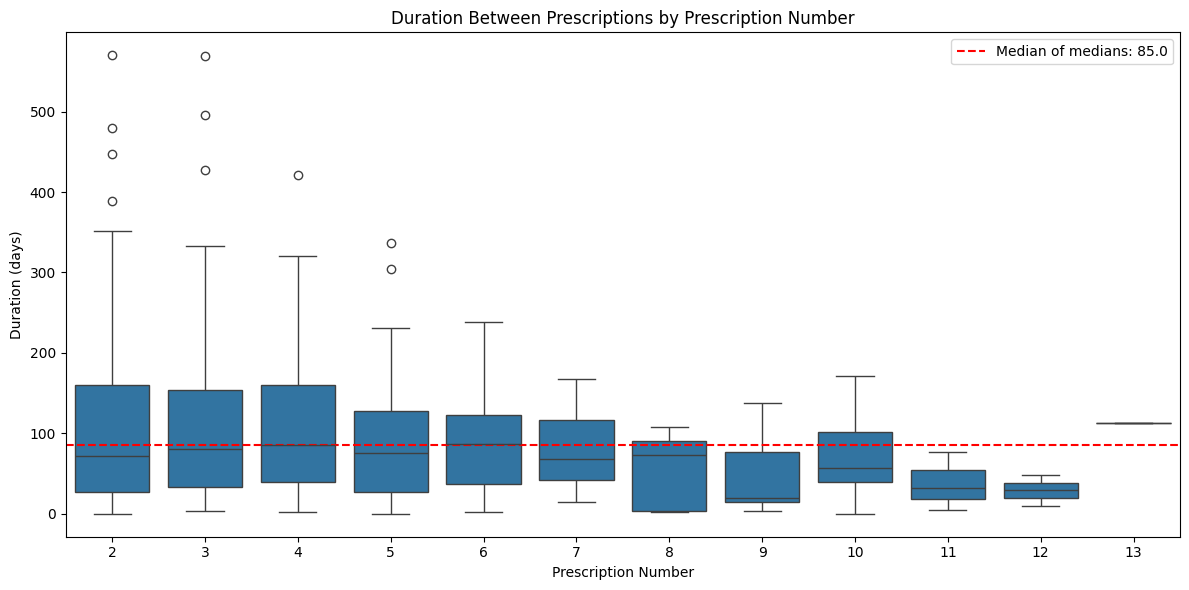

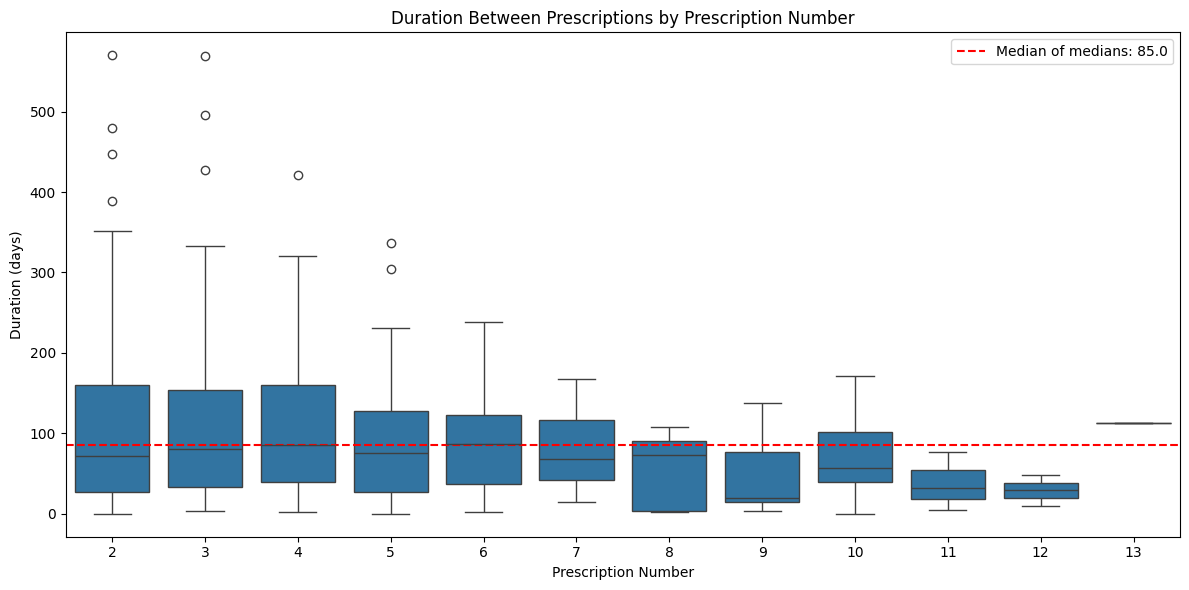

In [ ]:
see_assumption(medB_SEEDBScan)